
Thus far we've considered descriptive statistics to explore data.  We then expanded this to look at frequency dependence (via spectral analysis).  Next, we looked a how two time-series might be related using cross-correlation.  Here, we combine in a sense two ealier concepts, _i.e._, linear least-square fit (wherein we fit a line to data) and cross-correlations (wherein we compared two time-series).

Now we will look to fit one or more time-series to another.  In fact, the two data sets need not be time-dependent but can be functions of other independent varibles (_e.g._, location).  As an example, one might want to see how much variability in local temperatures might be explained by the El Nino/Southern Oscillation (ENSO).  In this case, the time-series of ENSO could be __regressed__ to the temperature, and then this could be removed.  In this case, the result would should temperature variations that are independent of ENSO variations.

## Regression of one time-series to another
Regression is a statistical technique you can use to explore (and model) the relationship between a dependent variable (the response variable) and one or more independent variables (the predictor or explanatory variables).

Regression analysis involves estimating the coefficients of the regression equation, which describe the relationship between the independent and dependent variables. There are different regression models, including linear regression, logistic regression, and polynomial regression.

With regression analysis, you’re trying to find the best-fit line or curve representing the variables’ relationship.  So, much like our line-fitting, LR is similar in the sense that instead of fitting a line to a time-series we fit a line to a property-property plot.

## Multiple linear regression

When there are two or more predictor variables, the model is called a multiple regression model. The general form of a multiple regression model is 

\begin{eqnarray}
   y_t = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon_t
\end{eqnarray}


where $y$ is the variable to be forecast and $x_1, x_2, x_3, ..., x_n$ are the $n$ predictor variables. Each of the predictor variables must be numerical. The coefficients $\beta_1, \beta_2, \beta_3, ..., \beta_n$ measure the effect of each predictor after taking into account the effects of all the other predictors in the model. Thus, the coefficients measure the marginal effects of the predictor variables.

## Assumptions

When we use a linear regression model, we are implicitly making some assumptions about the variables the equation above.

First, we assume that the model is a reasonable approximation to reality; that is, the relationship between the forecast variable and the predictor variables satisfies this linear equation.

Second, we make the following assumptions about the errors ($\epsilon_1, \epsilon_2, ..., \epsilon_T$)
  * they have mean zero; otherwise the forecasts will be systematically biased.
  * they are not autocorrelated; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
  * they are unrelated to the predictor variables; otherwise there would be more information that should be included in the systematic part of the model.

It is also useful to have the errors being normally distributed with a constant variance $\sigma^2$ in order to easily produce prediction intervals.

Another important assumption in the linear regression model is that each predictor $x$ is not a random variable. If we were performing a controlled experiment in a laboratory, we could control the values of each $x$ (so they would not be random) and observe the resulting values of $y$. With observational data (including most data in business and economics), it is not possible to control the value of $x$, we simply observe it. Hence we make this an assumption.



In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## Example: SST to known signals
In class last week we looked at sea surface temperature (SST) near Hawaii and saw a dominance of the annual cycle (warm in the summer and cold in winter).  A question might what other signals might be in this data set?  For example, major climate signals in the Pacific include things like El Nino (ENSO) and the Pacific Decadal Oscillation (PDO) (see for example https://www.climate.gov/enso and https://www.ncei.noaa.gov/access/monitoring/pdo/).

The process is to "best fit" an annual cycle to the data via linear regression, then look at the residuals.  Alternately, one could fit the ENSO cycle to the data.

### Load Sea Surface Temperature (SST)
For this notebook we'll load data from NOAA OceanWatch (https://coastwatch.noaa.gov/cwn/index.html, then Data Access --> Data Access Tools --> THREDDS catalog).  Similar to last time, we'll extract a point near Hawaii.

In [2]:
url = 'https://oceanwatch.pifsc.noaa.gov/thredds/dodsC/CRW-sst/monthly'
data = xr.open_dataset(url)

In [3]:
data

<xarray.Dataset> Size: 151GB
Dimensions:                  (lon: 7200, lat: 3600, time: 485)
Coordinates:
  * lon                      (lon) float32 29kB 0.025 0.075 ... 359.9 360.0
  * lat                      (lat) float32 14kB 89.97 89.93 ... -89.93 -89.97
  * time                     (time) datetime64[ns] 4kB 1985-01-31T12:00:00 .....
Data variables:
    crs                      int16 2B ...
    mask                     (time, lat, lon) float32 50GB ...
    sea_surface_temperature  (time, lat, lon) float64 101GB ...
Attributes: (12/60)
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    nco_openmp_thread_number:   1
    geospatial_lon_min:         0.025
    geospatial_lon_max:         359.975
    geospatial_bounds:          "POLYGON((-90.0 360.0, 90.0 360.0, 90.0 0.0, ...
    history:                    Thu May  1 07:32:46 2025: ncatted -O -a geosp...
    NCO:                        netCDF Operators version 4.7.5 (Homepage = ht...

In [4]:
# extract data from location near Hawaii
# longitude goes from 0 to 360 in this case, so Hawaii at
# 158W is 202
point_data = data.sel(lat=20,lon=202,method='nearest').squeeze()

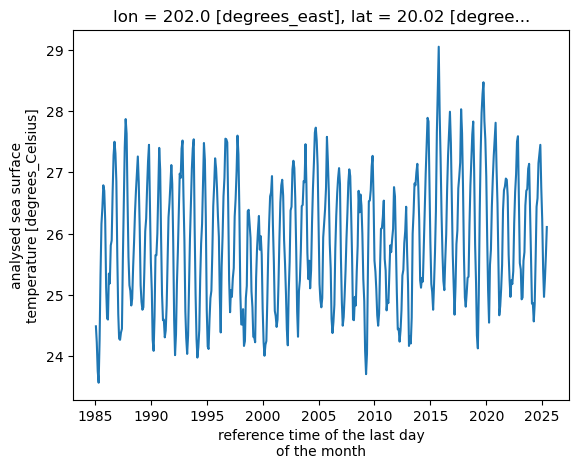

In [5]:
point_data.sea_surface_temperature.plot()

### ENSO and PDO
There are many climate signals available at https://psl.noaa.gov/data/timeseries/month/ and here we will access the Nino-3.4 and PDO.

In [6]:
# read data from PSL 

nino_url = 'https://psl.noaa.gov/data/timeseries/month/data/nino34.long.anom.data'
pdo_url = 'https://psl.noaa.gov/data/timeseries/month/data/pdo.timeseries.sstens.data'

# data are listed as each year in a separate row, each month of the 
#   year in a separate column; here we define the column headings to
#   match this
col_names = ['year','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# read data
#   skiprows = 1: skip top line (has year range)
#   header = None: no header
#   delim_whitespace = True: columns separated by white space
#   names = col_names: use the column headings defined above
#   on_bad_lines = 'skip': use this to ignore lines that don't have enough columns
nino = pd.read_csv(nino_url, skiprows = 1, header = None, delim_whitespace = True,
                  names = col_names, on_bad_lines = 'skip')
pdo = pd.read_csv(pdo_url, skiprows = 1, header = None, delim_whitespace = True,
                  names = col_names, on_bad_lines = 'skip')

# drop the last 9 lines (these have metadata we don't need
#   and the partial data for 2024)
nino.drop(nino.tail(9).index,inplace=True)
pdo.drop(pdo.tail(9).index,inplace=True)

/var/folders/00/m_p76xcd75jg4kx7_wyjwd500000gn/T/ipykernel_62110/2835033028.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino = pd.read_csv(nino_url, skiprows = 1, header = None, delim_whitespace = True,
/var/folders/00/m_p76xcd75jg4kx7_wyjwd500000gn/T/ipykernel_62110/2835033028.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pdo = pd.read_csv(pdo_url, skiprows = 1, header = None, delim_whitespace = True,


In [7]:
# reset dataframe to be continuous (each row a different month)
#   At this point the dataFrame has each year as a row, each month
#   of that year as a different column.  Instead, we want to have
#   just two columns, first one with the continuous date and the
#   second with the value for that month

A = nino.set_index('year')
B = A.stack().reset_index()
B.columns = ['year','month','NINO-3.4']

# Now convert year/month to a proper date
B['day'] = 15
B['month'] = pd.to_datetime(B.month,format='%b').dt.month
B['date'] = pd.to_datetime(B[['year','month','day']])
B.drop(columns = ['year','month','day'], inplace = True)
nino_new = B.reindex(columns = ['date','NINO-3.4'])
nino_new['NINO-3.4'] = pd.to_numeric(nino_new['NINO-3.4'])

A = pdo.set_index('year')
B = A.stack().reset_index()
B.columns = ['year','month','PDO']

# Now convert year/month to a proper date
B['day'] = 15
B['month'] = pd.to_datetime(B.month,format='%b').dt.month
B['date'] = pd.to_datetime(B[['year','month','day']])
B.drop(columns = ['year','month','day'], inplace = True)
pdo_new = B.reindex(columns = ['date','PDO'])
pdo_new['PDO'] = pd.to_numeric(pdo_new['PDO'])

In [8]:
pdo_new.head()

,date,PDO
0,1870-01-15,0.085
1,1870-02-15,0.017
2,1870-03-15,-0.068
3,1870-04-15,-0.593
4,1870-05-15,-0.587


### Have a look at these signals

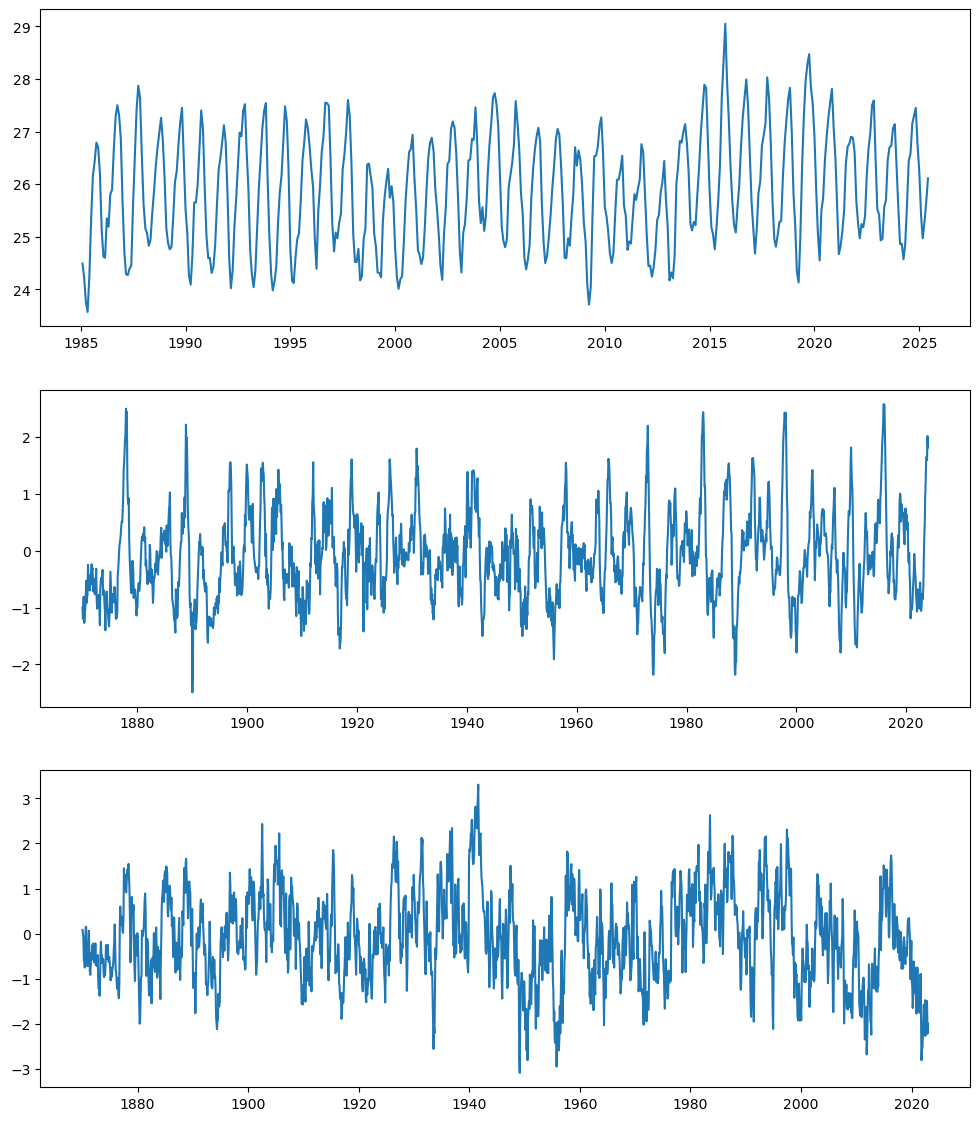

In [9]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(12,14))

ax[0].plot(point_data['time'],point_data['sea_surface_temperature'])
ax[1].plot(nino_new['date'],nino_new['NINO-3.4'])
ax[2].plot(pdo_new['date'],pdo_new['PDO'])

## MLR fit of these data

In [10]:
# Function to fit harmonics and compute trend of residuals
def fit_harm(time,input_var):
    var = pd.DataFrame(input_var)
    var.fillna(np.nanmean(var), inplace=True)
    nt = len(var)
    #t = mdates.date2num(time)
    t = time
# define basis functions, there will be one for the mean (0), two
#   for the daily cycle (1-2), two for the semi-annual harmonic (3-4), 
#   two for the annual cycle (5-6), and two for the decadal cycle (7-8)

#X = [[0 for I in range(len(var))] for J in range(9)]
    X = np.ones((nt,7),dtype=float)
    MonFit = np.ones(nt)
    w_mon = 2.0 * np.pi / 1.0
    w_san = w_mon * 2.0 / 12.0
    w_ann = w_mon / 12.0
    w_dec = w_mon / 120.0
    for k in range(nt):
        X[k,0] = 1
        X[k,1] = np.cos(k*w_san)
        X[k,2] = np.sin(k*w_san)
        X[k,3] = np.cos(k*w_ann)
        X[k,4] = np.sin(k*w_ann)
        X[k,5] = np.cos(k*w_dec)
        X[k,6] = np.sin(k*w_dec)

    alpha = 0.05
    Bfit = np.linalg.lstsq(X, var)[0] # ignore other outputs
    MonFit = X[:,1] * Bfit[1] + X[:,2] * Bfit[2] + X[:,3] * Bfit[3] \
        + X[:,4] * Bfit[4]
    fitvar = np.dot(X, Bfit)
    yresid = var - fitvar
    B = np.polyfit(t,yresid,1)
    YResidFit = np.polyval(B,t)
# get trend in [units] per decade (from per day)
    trend = B[0] * 365.25 * 10.0
    
    return(YResidFit,trend,MonFit)

In [11]:
# fit annual harm
sst = point_data.sea_surface_temperature.values
time = np.linspace(0,len(sst),len(sst))
res, trend, monfit = fit_harm(time,sst)

/var/folders/00/m_p76xcd75jg4kx7_wyjwd500000gn/T/ipykernel_62110/3263440698.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Bfit = np.linalg.lstsq(X, var)[0] # ignore other outputs


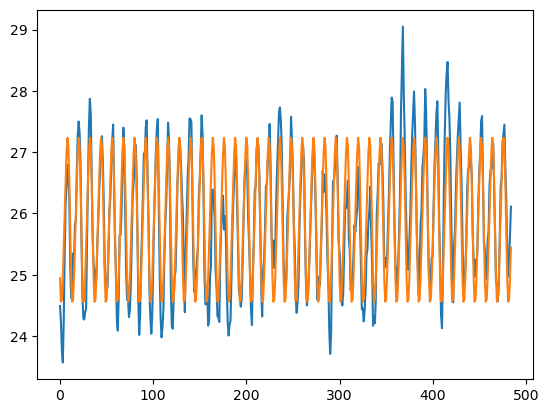

In [30]:
plt.plot(sst)
plt.plot(monfit+sst.mean());

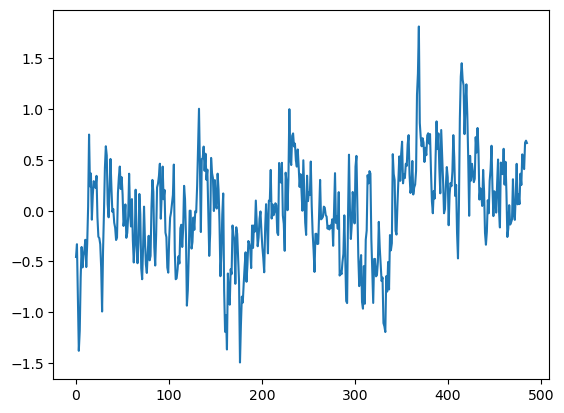

In [27]:
#plt.plot(time,sst-sst.mean())
sst_anom = sst-sst.mean() - monfit
plt.plot(time,sst_anom);

In [14]:
pd.DataFrame(sst-sst.mean() - monfit).describe()

,0
count,485.000000
mean,0.010050
std,0.485347
min,-1.495102
25%,-0.300090
50%,0.003312
75%,0.349980
max,1.814898


In [15]:
0.48*0.48/(1.06*1.06)*100

20.505517977928083

In [16]:
1.06*1.06

1.1236000000000002

In [17]:
pd.DataFrame(sst-sst.mean()-monfit).describe()

,0
count,485.000000
mean,0.010050
std,0.485347
min,-1.495102
25%,-0.300090
50%,0.003312
75%,0.349980
max,1.814898


In [18]:
point_data.sea_surface_temperature['time'][-1]

<xarray.DataArray 'time' ()> Size: 8B
array('2025-05-31T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    lon      float32 4B 202.0
    lat      float32 4B 20.02
    time     datetime64[ns] 8B 2025-05-31T12:00:00
Attributes:
    axis:                   T
    coverage_content_type:  coordinate
    long_name:              reference time of the last day of the month
    standard_name:          time
    _ChunkSizes:            1048576

In [53]:
# Note here that PDO is the limiting one as it ends in 2022
df1 = nino_new[(nino_new['date'] >= '1985-01-01') & ( nino_new['date'] <= '2022-12-31') ]
df2 = pdo_new[(pdo_new['date'] >= '1985-01-01') & ( pdo_new['date'] <= '2022-12-31') ]
xa2 = point_data.sel(time=slice('1985-01-01', '2022-12-31'))
sst2 = xa2.sea_surface_temperature.values
A = df1['NINO-3.4'].to_numpy()
B = df2['PDO'].to_numpy()

In [57]:
r1 = np.corrcoef(A,sst2)
r2 = np.corrcoef(B,sst2)
print('SST correlation with ENSO:', r1)
print('SST correlation with PDO:', r2)

SST correlation with ENSO: [[1.        0.1280581]
 [0.1280581 1.       ]]
SST correlation with PDO: [[1.        0.0901844]
 [0.0901844 1.       ]]
